<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

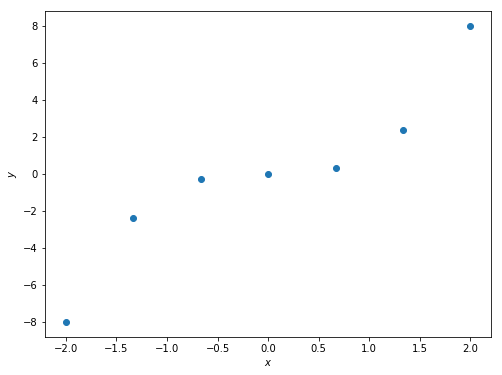

In [11]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

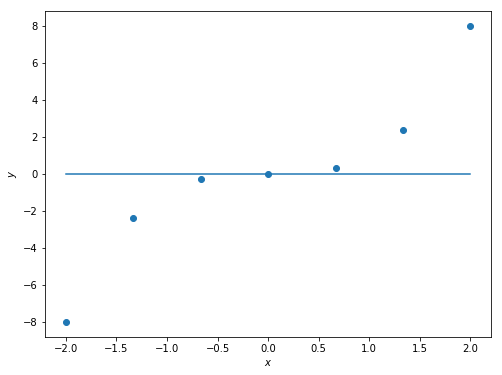

In [12]:
X = np.linspace(-2, 2, 7)
y = X ** 3
preds_0 = (X ** 3).mean()

plt.scatter(X, y);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.plot(X, [preds_0] * len(X));

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

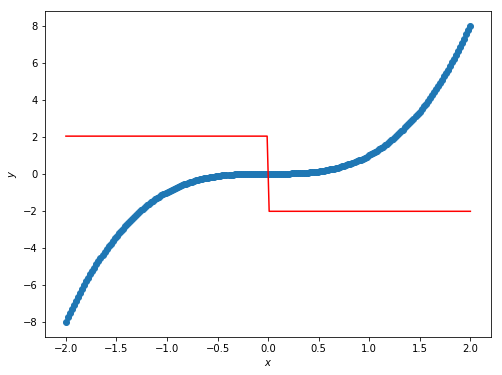

In [13]:
X = np.linspace(-2, 2, 200)
y = X ** 3

pred_thresh_0 = np.r_[[(X[X > 0] ** 3).mean()] * len(X[X > 0]), [(X[X <= 0] ** 3).mean()] * len(X[X <= 0])]

plt.scatter(X, y);
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.plot(X, pred_thresh_0, 'r');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [14]:
def regression_var_criterion(X, y, t):
    perem_dict = {}
    for ind, val in enumerate(X):
        perem_dict[val] = ind
        
    var_x = (1 / len(X)) * (np.sum(np.square((y - (1 / len(X)) * np.sum(y)))))
    y_l = np.array([y[perem_dict[val]] for val in X[X < t]])
    y_r = np.array([y[perem_dict[val]] for val in X[X >= t]])
    var_x_l = (1 / len(X[X < t])) * (np.sum(np.square((y_l - (1 / len(X[X < t])) * np.sum(y_l)))))
    var_x_r = (1 / len(X[X >= t])) * (np.sum(np.square((y_r - (1 / len(X[X >= t])) * np.sum(y_r)))))
    Q = var_x - (len(X[X < t]) / len(X)) * var_x_l - (len(X[X >= t]) / len(X)) * var_x_r
    return Q   

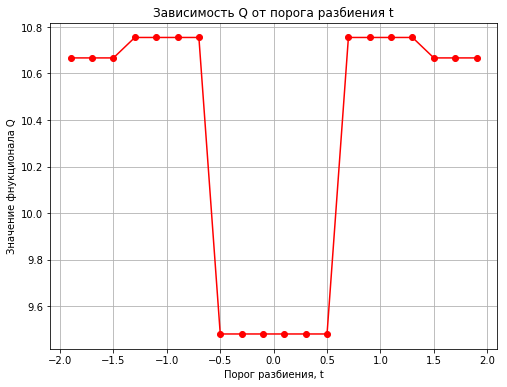

In [15]:
t = np.linspace(-1.9, 1.9, 20)
X = np.linspace(-2, 2, 7)
y = X ** 3

func_res = []
for znach in t:
    func_res.append(regression_var_criterion(X, y, znach))
    
plt.plot(t, np.array(func_res), 'ro-');
plt.title('Зависимость Q от порога разбиения t');
plt.xlabel('Порог разбиения, t');
plt.ylabel('Значение фнукционала Q');
plt.grid(True);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Ответ: нет, т.к. при данном пороге значение функционала Q минимально, а мы стреиммся его максимизировать

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [16]:
def get_tree_preds(X, y, t):
    perem_dict = {}
    for ind, val in enumerate(X):
        perem_dict[val] = ind
    
    X_left = X[X < t]
    X_right = X[X >= t]
    
    y_left = [y[perem_dict[x_l]] for x_l in X_left]
    y_right = [y[perem_dict[x_r]] for x_r in X_right]
    
    preds = []
    for num in range(len(X)):
        if X[num] in X_left:
            preds.append(np.mean(y_left))
        elif X[num] in X_right:
            preds.append(np.mean(y_right))
    return preds 

In [17]:
X_l = X[X < 0]
X_r = X[X >= 0]
print("Предсказания дерева для левой вершины:", get_tree_preds(X_l, X_l ** 3, -1.5), sep = " ")
print("Предсказания дерева для правой вершины:", get_tree_preds(X_r, X_r ** 3, 1.5), sep = " ")

Предсказания дерева для левой вершины: [-8.0, -1.3333333333333337, -1.3333333333333337]
Предсказания дерева для правой вершины: [0.8888888888888884, 0.8888888888888884, 0.8888888888888884, 8.0]


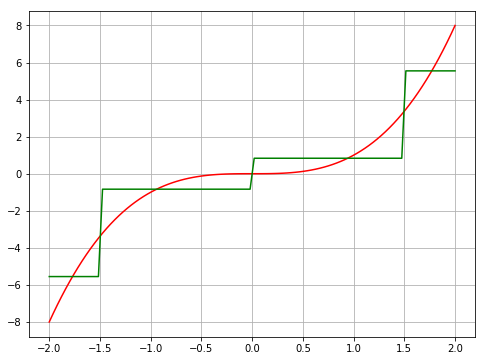

In [109]:
X = np.linspace(-2, 2, 100)
X_l = X[X < 0]
X_r = X[X >= 0]
plt.plot(X, X ** 3, 'red');
plt.plot(X, get_tree_preds(X_l, X_l ** 3, -1.5) + get_tree_preds(X_r, X_r ** 3, 1.5), 'g');
plt.grid(True);

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [73]:
df = pd.read_csv('https://github.com/Yorko/mlcourse_open/raw/master/data/mlbootcamp5_train.csv', 
                 index_col = 'id', sep = ';')

In [60]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [74]:
df['age_years'] = df['age'].apply(lambda age: int(age / 365))
chol_tab = pd.get_dummies(df['cholesterol'], prefix = 'cholesterol')
gluc_tab = pd.get_dummies(df['gluc'], prefix = 'gluc')
new_df = pd.concat([df, chol_tab, gluc_tab], axis = 1)
new_df = new_df.drop('age', axis = 1)
new_df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,1,1,0,0,1,0,50,1,0,0,1,0,0
1,1,156,85.0,140,90,3,1,0,0,1,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,3,1,0,0,0,1,51,0,0,1,1,0,0
3,2,169,82.0,150,100,1,1,0,0,1,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,1,1,0,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.drop('cardio', axis = 1), new_df['cardio'],
                                                     test_size = 0.3, random_state = 17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [76]:
derevo = DecisionTreeClassifier(random_state = 17, max_depth = 3)
derevo.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [77]:
from pydot import Dot as dot
export_graphviz(derevo, feature_names = list(set(new_df.columns) - {'cardio'}), 
out_file = 'heart_desease.dot', filled = True)
!dot -Tpng heart_desease.dot -o heart_desease.png

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Ответ: age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, derevo.predict(X_valid))

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [82]:
derevo_params = {'max_depth': list(range(2, 11)),
              'random_state': [17]}

tree_grid = GridSearchCV(derevo, derevo_params, cv = 5) # Ваш код здесь
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'random_state': [17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
tree_grid.best_params_

{'max_depth': 6, 'random_state': 17}

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

AttributeError: module 'matplotlib.pyplot' has no attribute 'gird'

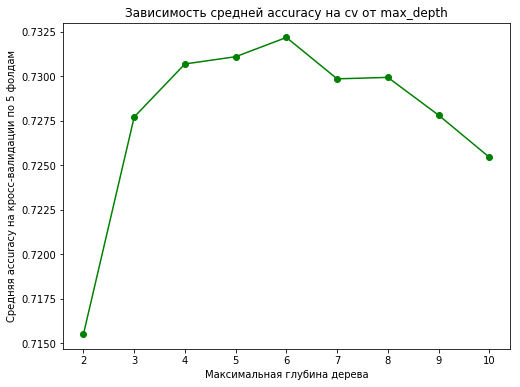

In [105]:
cv_scores = []
for depth in np.arange(2, 11):
    algo = DecisionTreeClassifier(random_state = 17, max_depth = depth)
    cv_scores.append(cross_val_score(algo, X_train, y_train, scoring = 'accuracy', cv = 5).mean())

plt.plot(np.arange(2, 11), np.array(cv_scores), 'go-');
plt.title('Зависимость средней accuracy на cv от max_depth');
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Средняя accuracy на кросс-валидации по 5 фолдам')
plt.gird(True);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [95]:
acc_grid = accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid))
acc_derevo = accuracy_score(y_valid, derevo.predict(X_valid))
100 * (acc_grid - acc_derevo) / acc_derevo

0.62718690169670033

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Ответ: да, нет.

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [99]:
recode_df = pd.get_dummies(new_df['cholesterol'], prefix = 'cholesterol')

# кодирование возраста
recode_df['age_45_50'] = new_df['age_years'].isin(np.arange(45, 50)).astype('int64')
recode_df['age_50_55'] = new_df['age_years'].isin(np.arange(50, 55)).astype('int64')
recode_df['age_55_60'] = new_df['age_years'].isin(np.arange(55, 60)).astype('int64')
recode_df['age_60_65'] = new_df['age_years'].isin(np.arange(60, 65)).astype('int64')

# кодирование верхнего давления
recode_df['ap_hi_120_140'] = new_df['ap_hi'].isin(np.arange(120, 140)).astype('int64')
recode_df['ap_hi_140_160'] = new_df['ap_hi'].isin(np.arange(140, 160)).astype('int64')
recode_df['ap_hi_160_180'] = new_df['ap_hi'].isin(np.arange(160, 180)).astype('int64')

recode_df['smoke'] = new_df['smoke']
recode_df['male'] = new_df['gender'].map({1: 0, 2: 1})

recode_df.shape

(70000, 12)

In [102]:
tree_recode = DecisionTreeClassifier(random_state = 17, max_depth = 3)


X_train_r, X_valid_r, y_train_r, y_valid_r = train_test_split(recode_df, new_df['cardio'],
                                                     test_size = 0.3, random_state = 17)
tree_recode.fit(X_train_r, y_train_r)

export_graphviz(tree_recode, feature_names = list(X_train_r.columns), 
out_file = 'recoded_tree.dot', filled = True)

!dot -Tpng recoded_tree.dot -o recoded_tree.png

Ответ: Верхнее артериальное давление от 140 до 160 (мм рт.ст.)